In [4]:
!pip install tensorflow
!pip install torch
!pip install wandb
!pip install torchvision
!pip install pytorch_lightning

In [1]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
import torchvision
import matplotlib.pyplot as plt
import os,math,re
import ast
import cv2
import wandb
import matplotlib.patches as patches

In [2]:
train_path='C:/Users/shree/ML DEEP Learning Programs/global-wheat-detection/train/'
BASE_DIR='C:/Users/shree/ML DEEP Learning Programs/global-wheat-detection/'
train_df=pd.read_csv('C:/Users/shree/ML DEEP Learning Programs/global-wheat-detection/train.csv')
test_df=pd.read_csv('C:/Users/shree/ML DEEP Learning Programs/global-wheat-detection/sample_submission.csv')
train_df['paths']=train_path+train_df['image_id']+'.jpg'
display(train_df)
display(test_df)

print(f'We have {train_df.paths.nunique()} unique images and {len(train_df)} detections')
print(f'Which means we have {len(train_df)/train_df.paths.nunique()} detections per image')



image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

                                                    paths  
0       C:/Users/shree/ML DEEP Learning Programs/globa...  
1       C:/Users/shree/ML DEEP Learning Programs/globa...  
2       C:/Users/shree/ML DEEP Learning Programs/globa...  
3       C:/Users/shree/ML DEEP Learning Programs/globa...  
4       C:/Users/shree/ML DEEP Learning Programs/globa...  
...                                                   ...  
147788  C:/Users/shree/ML DEEP Learning Programs/globa...  
147789  C:/Users/shree/ML DEEP Learning Programs/globa...  
147790  C:/Users/shree/ML DEEP Learning Programs/globa...  
147791  C:/Users/shree/ML DEEP Learning Programs/globa...  
147792  C:/Users/shree/ML DEEP Learning Programs/globa...  

[147793 rows x 6 columns]

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50
5  348a992bb    1.0 0 0 50 50
6  cc3532ff6    1.0 0 0 50 50
7  2fd875eaa    1.0 0 0 50 50
8  cb8d261a3    1.0 0 0 50 50
9  53f253011    1.0 0 0 50 50

We have 3373 unique images and 147793 detections
Which means we have 43.8164838422769 detections per image


In [3]:
train_df = train_df.groupby("image_id")["bbox"].apply(list).reset_index(name="bboxes")

In [4]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))


train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df['area'] = train_df['width'] * train_df['height']
train_df['x_max'] = train_df['x_min'] + train_df['width']
train_df['y_max'] = train_df['y_min'] + train_df['height']
train_df = train_df.drop(['bbox'], axis=1)
train_df = train_df[['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height', 'area', 'source']]


train_df = train_df[train_df['area'] < 100000]

train_df.head()

image_id  x_min  y_min  x_max  y_max  width  height     area   source
0  b6ab77fd7  834.0  222.0  890.0  258.0   56.0    36.0   2016.0  usask_1
1  b6ab77fd7  226.0  548.0  356.0  606.0  130.0    58.0   7540.0  usask_1
2  b6ab77fd7  377.0  504.0  451.0  664.0   74.0   160.0  11840.0  usask_1
3  b6ab77fd7  834.0   95.0  943.0  202.0  109.0   107.0  11663.0  usask_1
4  b6ab77fd7   26.0  144.0  150.0  261.0  124.0   117.0  14508.0  usask_1

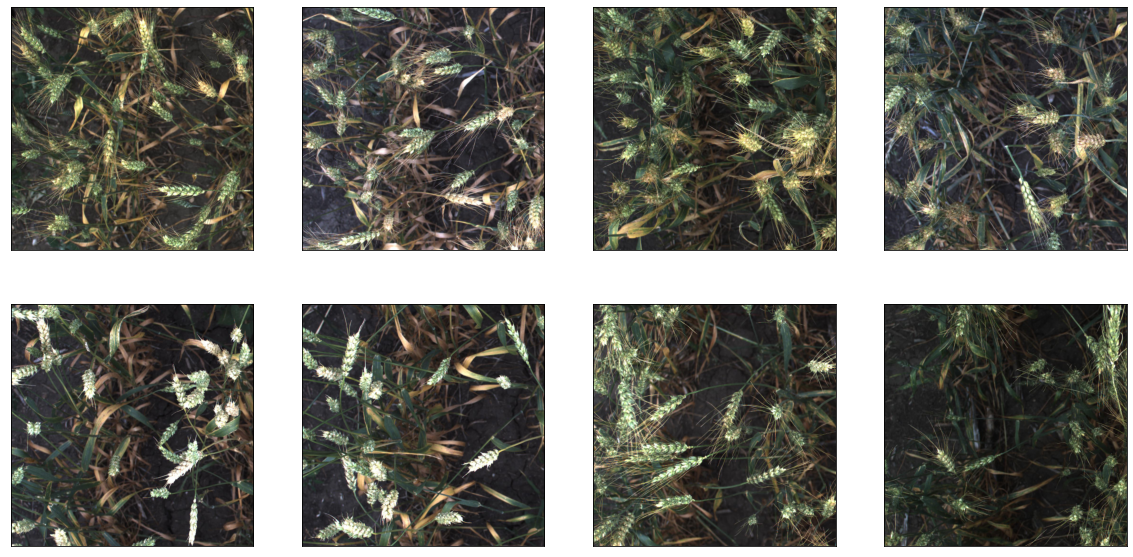

In [5]:
fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))

count=0
for row in ax:
    for col in row:
        img=plt.imread(f'{os.path.join(train_path,train_df["image_id"].unique()[count])}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count+=1
plt.show()

In [6]:
def get_bbox(train_df,df,col,color='white'):
    bboxes=df[df['image_id']==train_df]
    
    for i in range(len(bboxes)):
        
        rect=patches.Rectangle(
        (bboxes['x_min'].iloc[i],bboxes['y_min'].iloc[i]),
        bboxes['width'].iloc[i],
        bboxes['height'].iloc[i],
        linewidth=2,
        edgecolor=color,
        facecolor='none')
        
        col.add_patch(rect)

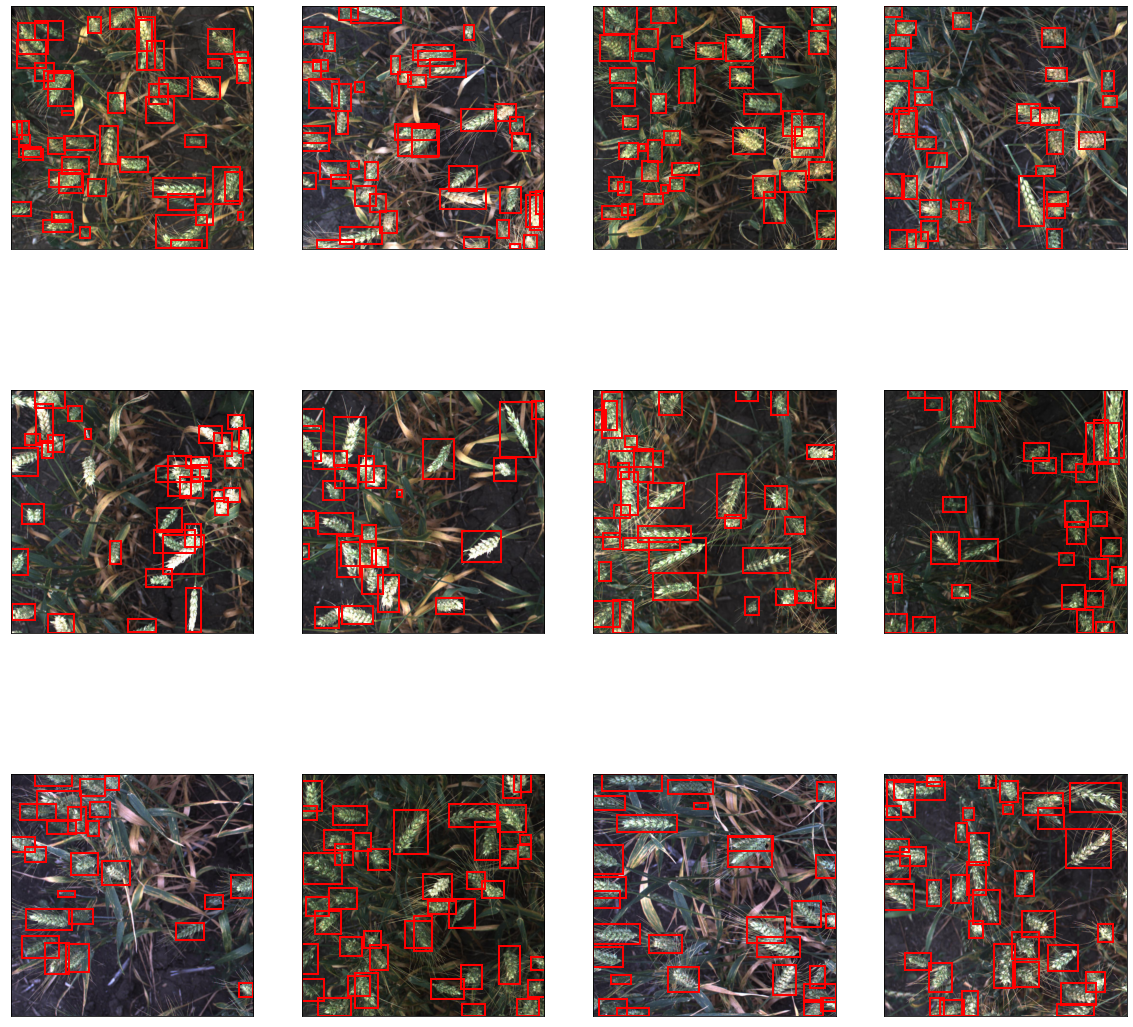

In [7]:
fig, ax= plt.subplots(nrows=3,ncols=4,figsize=(20,20))
count=0
for row in ax:
    for col in row:
        img_id=train_df['image_id'].unique()[count]
        img=plt.imread(f'{os.path.join(BASE_DIR,"train",img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(img_id,train_df,col,color='red')
        col.imshow(img)
        count +=1
plt.show()

[]

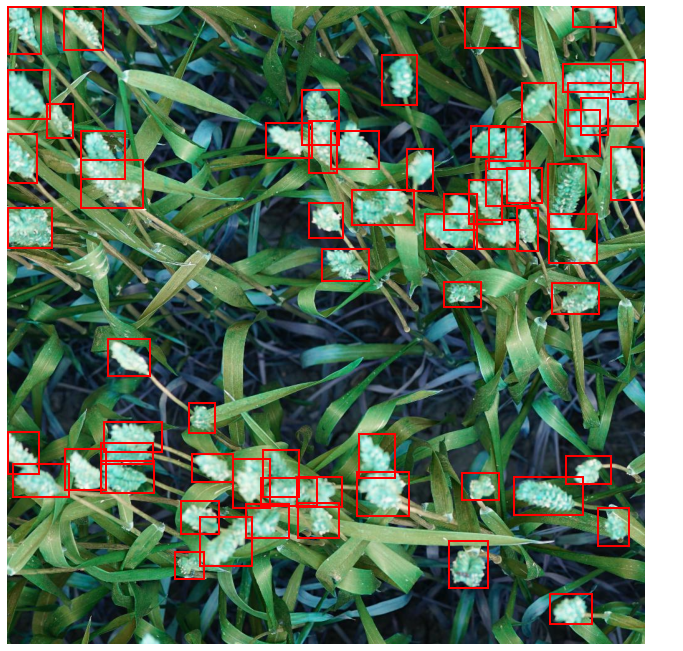

In [8]:
image_id = 'c14c1e300'
image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)

fig, ax=plt.subplots(1,figsize=(12,12))

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
get_bbox(image_id,train_df,ax,color='red')
ax.imshow(image)
plt.plot()

In [9]:
all_images = os.listdir(os.path.join(BASE_DIR, 'train'))
all_images = set([x[:-4] for x in all_images])

images_with_bbox = set(list(train_df['image_id']))

images_without_bbox = list(all_images - images_with_bbox)

In [10]:
print(f'Total number of images without wheat heads: {len(images_without_bbox)}')

Total number of images without wheat heads: 49


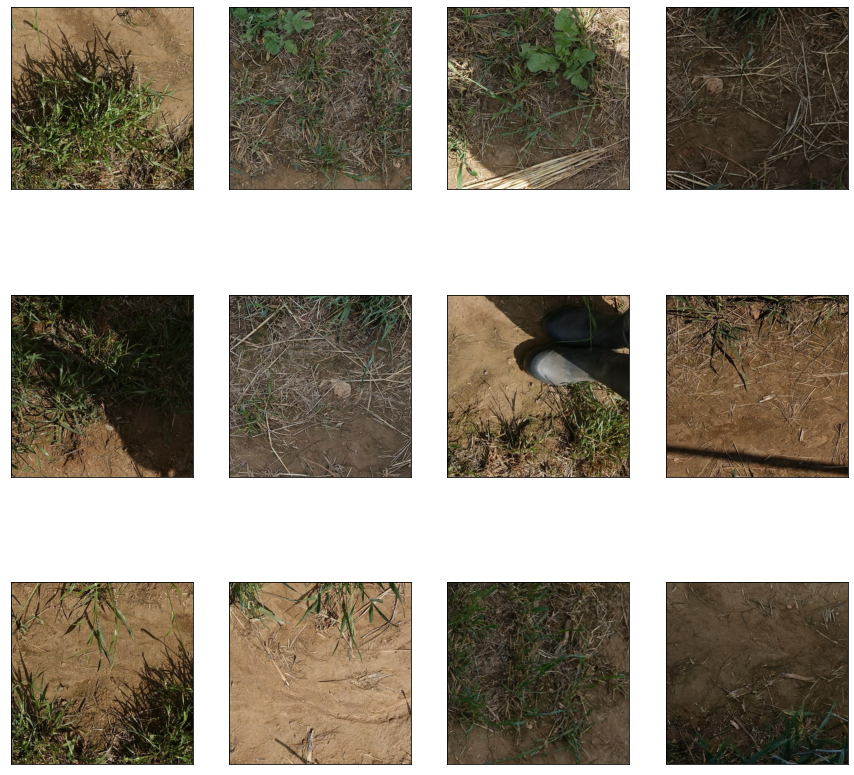

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,15))
count=20
for row in ax:
    for col in row:
        img_id = images_without_bbox[count]
        img = plt.imread(f'{os.path.join(BASE_DIR, "train", img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()

# Virakshi Virendra Padma

TCR-Innovation Internship Final Project 1 (Global Wheat Head Detection)